## Example of audio augmentation

This notebook demonstrates how to perform audio augmentation using the `Muda` and `librosa` library.

In this example, we will perform the following audio augmentations:

1. Pitch shifting
2. Time stretching
3. Dynamic range compression



In [ ]:
from xai_music import Audiobank

audio_bank = Audiobank(config_file='configuration.yml')
audio_bank.synthesis()

## Plotting example of audio

In [14]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

from IPython import display

In [15]:
def plot_audio(path: str) -> None:
    # Load the audio file
    y, sr = librosa.load(path, sr=16000)
    # Compute the spectrogram
    spectrogram = librosa.stft(y)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

    # Plotting
    fig, axes = plt.subplots(2, figsize=(12, 8))

    # Waveform plot
    timescale = np.arange(y.shape[0])
    axes[0].plot(timescale, y)
    axes[0].set_title('Waveform')
    axes[0].set_xlim([0, y.shape[0]])

    # Spectrogram plot
    img = librosa.display.specshow(
        spectrogram_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Spectrogram')
    fig.colorbar(img, ax=axes[1], format="%+2.0f dB")

    # Title and show
    plt.suptitle(path.split('/')[-1].title())
    plt.show()

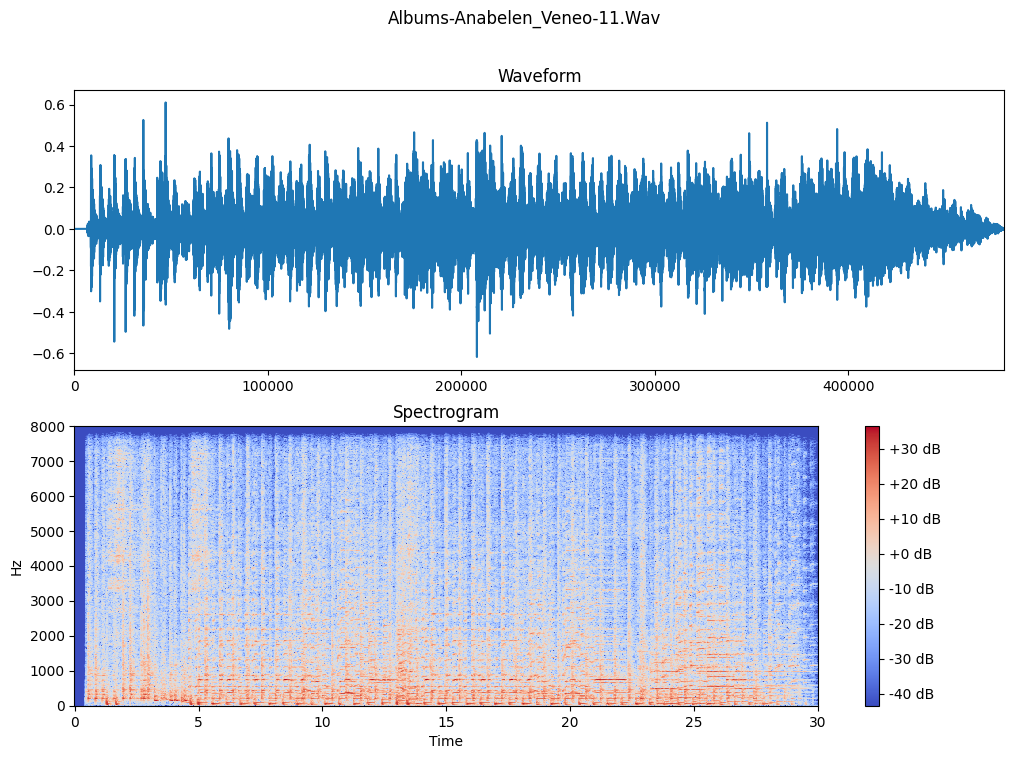

In [16]:
_MUSIC_PATH=r'wavfiles/Quickstep/Albums-AnaBelen_Veneo-11.wav'

plot_audio(_MUSIC_PATH)
display.display(display.Audio(_MUSIC_PATH, rate=16000))

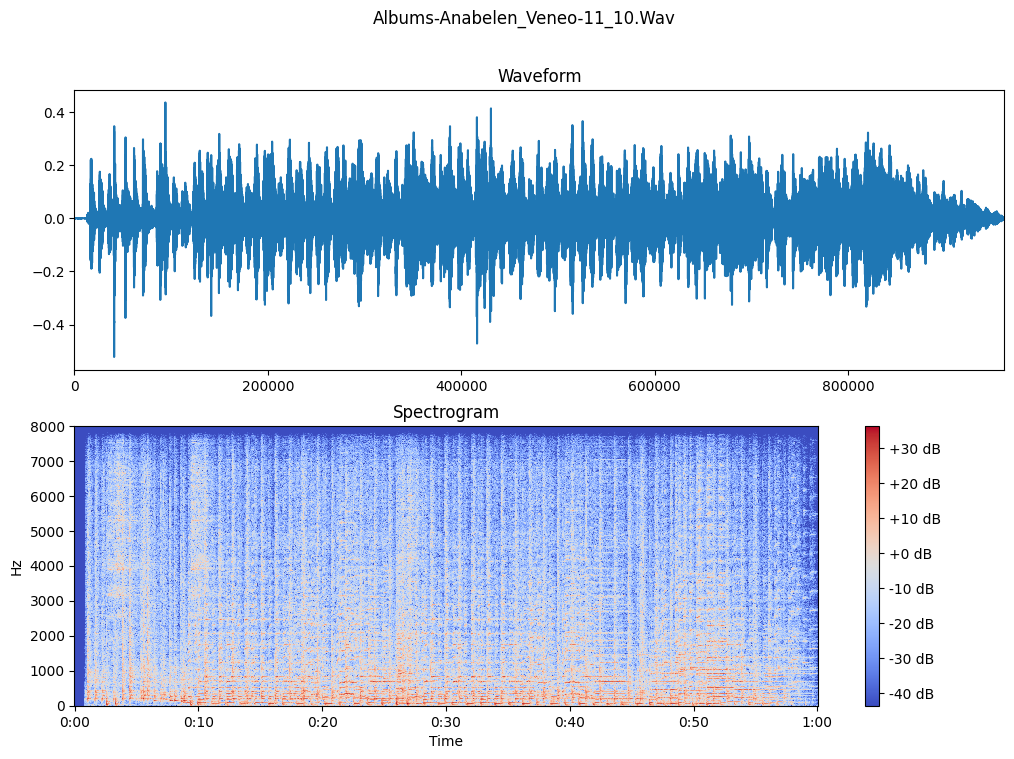

In [17]:
_MUSIC_PATH=r'audio/augments/wav/Quickstep/Albums-AnaBelen_Veneo-11_10.wav'

plot_audio(_MUSIC_PATH)
display.display(display.Audio(_MUSIC_PATH, rate=16000))

This is the meta dat of audio augmentation file `audio/augments/wav/Quickstep/Albums-AnaBelen_Veneo-11_10.wav`

```json
    {
    "annotations": [],
    "file_metadata": {
        "title": "",
        "artist": "",
        "release": "",
        "duration": 60.09505668934241,
        "identifiers": {},
        "jams_version": "0.3.4"
    },
    "sandbox": {
        "muda": {
        "history": [
            {
            "transformer": {
                "__class__": "LogspaceTimeStretch",
                "params": {
                "lower": -1.0,
                "n_samples": 5,
                "upper": 1.0
                }
            },
            "state": {
                "rate": 0.5
            }
            },
            {
            "transformer": {
                "__class__": "LinearPitchShift",
                "params": {
                "lower": -2.0,
                "n_samples": 5,
                "upper": 2.0
                }
            },
            "state": {
                "tuning": -0.12,
                "n_semitones": -1.0
            }
            },
            {
            "transformer": {
                "__class__": "DynamicRangeCompression",
                "params": {
                "preset": [
                    "radio",
                    "film standard",
                    "film light",
                    "music standard",
                    "music light",
                    "speech"
                ]
                }
            },
            "state": {
                "preset": "music light"
            }
            }
        ],
        "state": [],
        "version": {
            "muda": "0.4.1",
            "librosa": "0.10.1",
            "jams": "0.3.4",
            "pysoundfile": "0.9.0"
        }
        }
    }
    }
```


## Extract augmentation features from jams file



In [45]:
import pandas as pd
import json
import os


def extract_info_from_file(file_path: str) -> tuple:
    with open(file_path, "r") as file:
        data = json.load(file)
        # Initialize variables to store the extracted information
        n_semitones, rate, preset = None, None, None
        # Loop through the history of transformations to extract the required information
        for transformation in (
            data.get("sandbox", {}).get("muda", {}).get("history", [])
        ):
            transformer_class = transformation.get("transformer", {}).get(
                "__class__", ""
            )
            if transformer_class == "LinearPitchShift":
                n_semitones = transformation.get("state", {}).get("n_semitones")
            elif transformer_class == "LogspaceTimeStretch":
                rate = transformation.get("state", {}).get("rate")
            elif transformer_class == "DynamicRangeCompression":
                preset = transformation.get("state", {}).get("preset")
        return n_semitones, rate, preset


def create_dataframe_from_dir(directory_path: str) -> pd.DataFrame:
    # Define the DataFrame columns
    df = pd.DataFrame(columns=["n_semitones", "rate", "preset", "type"])
    # Preset list for mapping
    preset_list = [
        "radio",
        "film standard",
        "film light",
        "music standard",
        "music light",
        "speech",
    ]
    # Iterate over each file in the directory
    file_list = [
        os.path.join(root, file)
        for root, dirs, files in os.walk(directory_path)
        for file in files
        if file.endswith(".jams")
    ]
    for file_name in file_list:
        n_semitones, rate, preset = extract_info_from_file(file_name)
        # Extract type of music from the file path or name
        type_of_music = file_name.split("/")[-2]
        # Append the extracted information to the DataFrame
        new_row = pd.DataFrame(
            {
                "n_semitones": [n_semitones],
                "rate": [rate],
                "preset": [preset],
                "type": [type_of_music],
            }
        )
        df = pd.concat([df, new_row], ignore_index=True)
    # Convert preset to index
    df["preset"] = df["preset"].apply(
        lambda x: preset_list.index(x) if x in preset_list else None
    )
    return df

In [46]:
_jams_output_dir=r'audio/augments/meta'
# Create the DataFrame
df = create_dataframe_from_dir(_jams_output_dir)
# Display the DataFrame
df

/tmp/ipykernel_436811/967338221.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


n_semitones      rate  preset       type
0           -2.0  0.500000       0  Quickstep
1            2.0  2.000000       1  Quickstep
2           -2.0  1.414214       2  Quickstep
3            1.0  1.414214       1  Quickstep
4            0.0  1.000000       1  Quickstep
..           ...       ...     ...        ...
145          2.0  0.500000       5  Quickstep
146          0.0  1.000000       5  Quickstep
147          0.0  0.707107       1  Quickstep
148         -1.0  1.000000       1  Quickstep
149         -2.0  0.707107       0  Quickstep

[150 rows x 4 columns]

In [44]:
df.drop(columns=['type'], inplace=True)
df


n_semitones      rate  preset
0           -2.0  0.500000       0
1            2.0  2.000000       1
2           -2.0  1.414214       2
3            1.0  1.414214       1
4            0.0  1.000000       1
..           ...       ...     ...
145          2.0  0.500000       5
146          0.0  1.000000       5
147          0.0  0.707107       1
148         -1.0  1.000000       1
149         -2.0  0.707107       0

[150 rows x 3 columns]